In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import SpectralEmbedding, LocallyLinearEmbedding, Isomap, TSNE
import umap
import GPy
import seaborn as sns
from scipy.sparse.csgraph import shortest_path
from scipy.sparse import csr_matrix
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import sys
sys.path.append('../..')
from vae import MyVAE
import time

import imp

from ikd import utils, core, evaluate, datasets
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)

<module 'ikd.datasets' from '/storage/scratch1/1/cli726/ikd/ikd/ikd/datasets.py'>

In [5]:
x = np.zeros((1440, 16384))
y = np.zeros(1440)
for i in range(20):
    for j in range(72):
        x[i*72 + j] = mpimg.imread(f'data/coil-20-proc/obj{i+1}__{j}.png').flatten()
        y[i*72 + j] = i

In [ ]:
method_list = ['PCA', 'KPCA', 'LE', 'Isomap', 'TSNE', 'UMAP', 'GPLVM', 'VAE', 'IKD']
d_latent_list = [2, 3, 5, 10]

In [ ]:
def method_fit_transform(method, x, d_latent):
    if method == 'PCA':
        return PCA(n_components=d_latent).fit_transform(x)
    elif method == 'KPCA':
        return KernelPCA(n_components=d_latent, kernel='poly').fit_transform(x)
    elif method == 'LE':
        return SpectralEmbedding(n_components=d_latent).fit_transform(x)
    elif method == 'Isomap':
        return Isomap(n_components=d_latent).fit_transform(x)
    elif method == 'TSNE':
        if d_latent <= 3:
            return TSNE(n_components=d_latent, init='pca', learning_rate='auto', random_state=42).fit_transform(x)
        else:
            return TSNE(n_components=d_latent, init='pca', learning_rate='auto', random_state=42, method='exact').fit_transform(x)
    elif method == 'UMAP':
        return umap.UMAP(n_components=d_latent, random_state=42).fit_transform(x)
    elif method == 'GPLVM':
        m_gplvm = GPy.models.GPLVM(x, d_latent, kernel=GPy.kern.RBF(d_latent, variance=1, lengthscale=1))
        m_gplvm.likelihood.variance = 1.
        m_gplvm.optimize(max_iters=20, messages=0)
        z_gplvm = m_gplvm.X.values
        return z_gplvm
    elif method == 'VAE':
        return MyVAE(n_components=d_latent, epochs=100).fit_transform(x)
    elif method == 'IKD':
        return core.ikd_geodesic(x, d_latent=d_latent, ref_point='center')

In [ ]:
df_z = pd.DataFrame(columns=['z', 'method', 'd_latent', 'runtime'], dtype=object)

# preheat
for method in method_list:
    method_fit_transform(method, x, 2)
for method in method_list:
    for d_latent in d_latent_list:
        s = time.time()
        z = method_fit_transform(method, x, d_latent)
        e = time.time()
        df_z.loc[len(df_z)] = [z, method, d_latent, e-s]
        print(method, d_latent)

df_z.to_pickle(f'z.pkl')

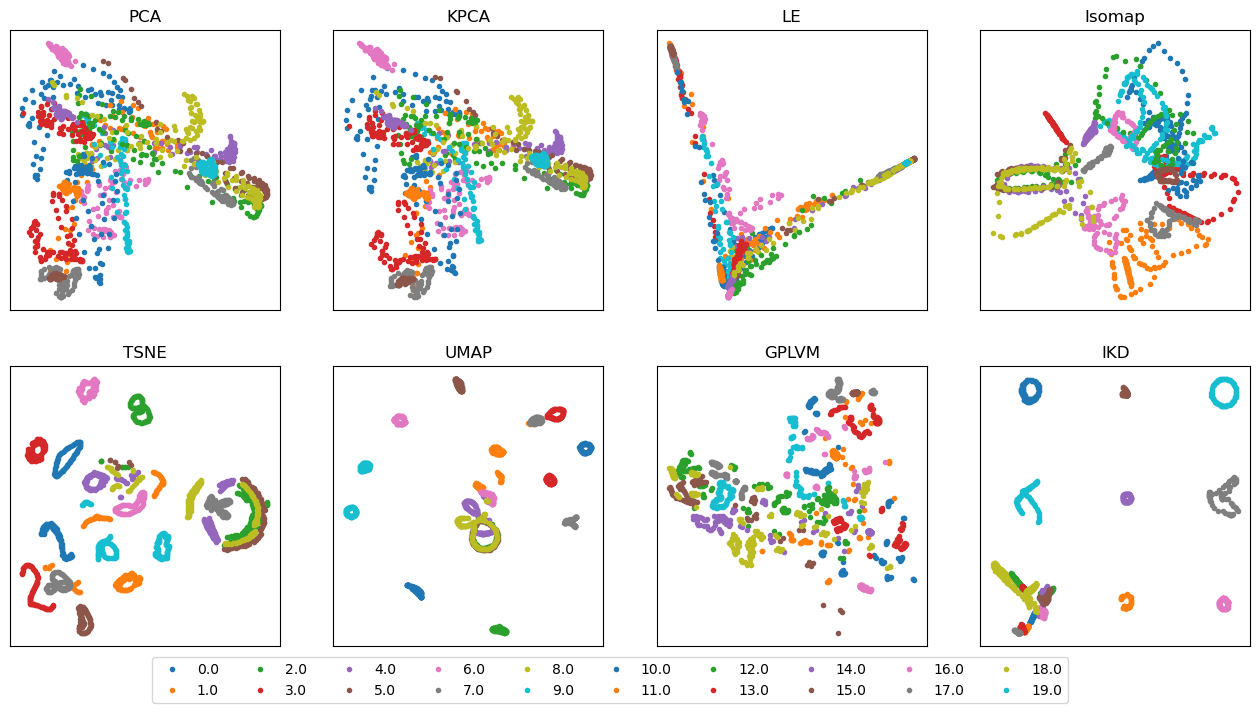

In [21]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
for i in range(2):
    for j in range(4):
        method = list(z.keys())[4*i+j]
        z_pred = z[method]
        for k in np.unique(y):
            idx = y == k
            axs[i, j].plot(z_pred[idx, 0], z_pred[idx, 1], '.', label=f'{k}')
            axs[i, j].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
            axs[i, j].set_title(method)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.03), ncol=10)
fig.savefig('COIL-20.pdf', bbox_inches='tight')

<AxesSubplot:xlabel='k', ylabel='accuracy'>

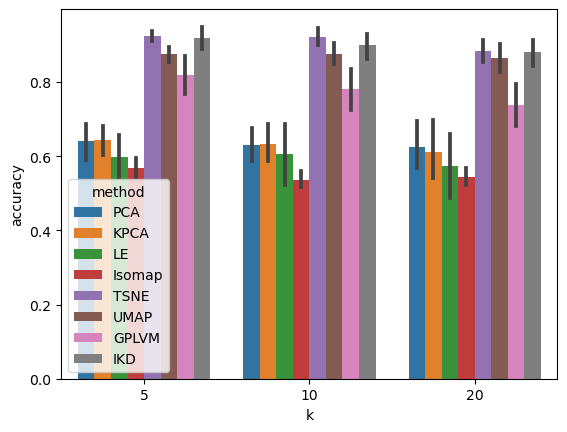

In [3]:
df = pd.read_csv('COIL-20.csv', index_col=0)
sns.barplot(data=df, x='k', y='accuracy', hue='method')

In [4]:
k_list = [5, 10, 20]
method_list = list(z.keys())
print('$k$', end='')
for j in range(8):
    print(f' & {method_list[j]}', end='')
print('\\\\')
for i in range(len(k_list)):
    print(f'{k_list[i]}', end='')
    for j in range(8):
        temp = df.loc[(df.k == k_list[i]) & (df.method == method_list[j])]
        print(f' & {temp.accuracy.mean():.2f}\\tiny{{$\pm${temp.accuracy.std():.2f}}}', end='')
        if j == 7:
            print('\\\\')

$k$ & PCA & KPCA & LE & Isomap & TSNE & UMAP & GPLVM & IKD\\
5 & 0.64\tiny{$\pm$0.06} & 0.64\tiny{$\pm$0.05} & 0.60\tiny{$\pm$0.07} & 0.57\tiny{$\pm$0.04} & 0.92\tiny{$\pm$0.02} & 0.88\tiny{$\pm$0.03} & 0.82\tiny{$\pm$0.07} & 0.92\tiny{$\pm$0.04}\\
10 & 0.63\tiny{$\pm$0.06} & 0.63\tiny{$\pm$0.06} & 0.60\tiny{$\pm$0.11} & 0.54\tiny{$\pm$0.03} & 0.92\tiny{$\pm$0.03} & 0.88\tiny{$\pm$0.04} & 0.78\tiny{$\pm$0.07} & 0.90\tiny{$\pm$0.04}\\
20 & 0.62\tiny{$\pm$0.08} & 0.61\tiny{$\pm$0.10} & 0.57\tiny{$\pm$0.12} & 0.55\tiny{$\pm$0.03} & 0.88\tiny{$\pm$0.04} & 0.86\tiny{$\pm$0.05} & 0.74\tiny{$\pm$0.07} & 0.88\tiny{$\pm$0.05}\\
